In [38]:
# Fill in your name using the given format
your_name = "Hu, Ruichen"

In [39]:
# For use in colab
from IPython import get_ipython
if 'google.colab' in str(get_ipython()):
    !pip install openml --quiet
    !pip install category_encoders --quiet
    !pip install dirty_cat --quiet

# Assignment 2
In this assignment we will focus on handling somewhat 'messy' real-world datasets that require thoughtful preprocessing, rather than just a grid search over all possible models. We will use the [Employee Salary dataset](https://www.openml.org/d/42125), which contains information about the salaries of all people working in a local government in the USA. In the end we will aim to predict salaries, and study whether there are certain biases in the data (or in our models) that we need to be aware of and how to avoid them when training models.

In [40]:
# imports
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import openml
import time
start_time = time.time()

# ignore future warnings
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

In [41]:
# Pre-flight checklist. Do not change this code.
# Make sure that you have installed recent versions of key packages.
# You could lose points if these checks do not pass.
from packaging import version
import sklearn
import category_encoders
import seaborn
import sys

# install dirty_cat if needed
if 'dirty_cat' not in sys.modules:
    !pip install dirty_cat --quiet

sklearn_version = sklearn.__version__
catencoder_version = category_encoders.__version__
if version.parse(sklearn_version) < version.parse("1.0.2"):
    print("scikit-learn is outdated. Please update now!")
elif version.parse(catencoder_version) < version.parse("2.0.0"):
    print("category_encoders is outdated. Please update now!")
else:
    print("OK. You may continue :)")

OK. You may continue :)


In [42]:
# Download Employee Salary data. Do not change this code!
# Note that X is a pandas dataframe 
salary = openml.datasets.get_dataset(42125)
X, y, _, feat_names = salary.get_data(target=salary.default_target_attribute)

### Exploring the data
A first useful step is to take a closer look at the dataset and how the features are distributed.

In [43]:
# Peek at the remaining data
X

,full_name,gender,2016_gross_pay_received,2016_overtime_pay,department,department_name,division,assignment_category,employee_position_title,underfilled_job_title,date_first_hired,year_first_hired
0,"Aarhus, Pam J.",F,71225.98,416.10,POL,Department of Police,MSB Information Mgmt and Tech Division Records...,Fulltime-Regular,Office Services Coordinator,None,09/22/1986,1986
1,"Aaron, David J.",M,103088.48,3326.19,POL,Department of Police,ISB Major Crimes Division Fugitive Section,Fulltime-Regular,Master Police Officer,None,09/12/1988,1988
2,"Aaron, Marsha M.",F,107000.24,1353.32,HHS,Department of Health and Human Services,Adult Protective and Case Management Services,Fulltime-Regular,Social Worker IV,None,11/19/1989,1989
3,"Ababio, Godfred A.",M,57819.04,3423.07,COR,Correction and Rehabilitation,PRRS Facility and Security,Fulltime-Regular,Resident Supervisor II,None,05/05/2014,2014
4,"Ababu, Essayas",M,95815.17,NaN,HCA,Department of Housing and Community Affairs,Affordable Housing Programs,Fulltime-Regular,Planning Specialist III,None,03/05/2007,2007
...,...,...,...,...,...,...,...,...,...,...,...,...
9223,"Zurita, Justina",F,58154.47,NaN,HHS,Department of Health and Human Services,School Based Health Centers,Fulltime-Regular,Community Health Nurse II,None,11/03/2015,2015
9224,"Zuspan, Diane M.",F,173173.01,956.97,FRS,Fire and Rescue Services,Human Resources Division,Fulltime-Regular,Fire/Rescue Division Chief,None,11/28/1988,1988
9225,"Zwerdling, David",M,104238.18,NaN,HHS,Department of Health and Human Services,Child and Adolescent Mental Health Clinic Serv...,Parttime-Regular,Medical Doctor IV - Psychiatrist,None,04/30/2001,2001
9226,"Zyontz, Jeffrey L.",M,149105.25,NaN,CCL,County Council,Council Central Staff,Fulltime-Regular,Manager II,None,09/05/2006,2006


The labels (y) contain the salaries for 2017.

In [44]:
y

0        69222.18
1        97392.47
2       104717.28
3        52734.57
4        93396.00
          ...    
9223     72094.53
9224    169543.85
9225    102736.52
9226    153747.50
9227     75484.08
Name: current_annual_salary, Length: 9228, dtype: float64

The first thing we notice is that there are missing values in the input data (but not in the labels). Let's see how bad it is, and which features have the most missing values.

In [45]:
# Check the column data types and missing data
# Some features have significant amounts of missing values
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9228 entries, 0 to 9227
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   full_name                9228 non-null   object  
 1   gender                   9211 non-null   category
 2   2016_gross_pay_received  9128 non-null   float64 
 3   2016_overtime_pay        6311 non-null   float64 
 4   department               9228 non-null   category
 5   department_name          9228 non-null   category
 6   division                 9228 non-null   object  
 7   assignment_category      9228 non-null   category
 8   employee_position_title  9228 non-null   object  
 9   underfilled_job_title    1093 non-null   object  
 10  date_first_hired         9228 non-null   object  
 11  year_first_hired         9228 non-null   int64   
dtypes: category(4), float64(2), int64(1), object(5)
memory usage: 615.8+ KB


Some categorical columns have a large number of possible values. Especially the job position titles can take many different values, with a highly skewed distribution. This will be tricky to handle.

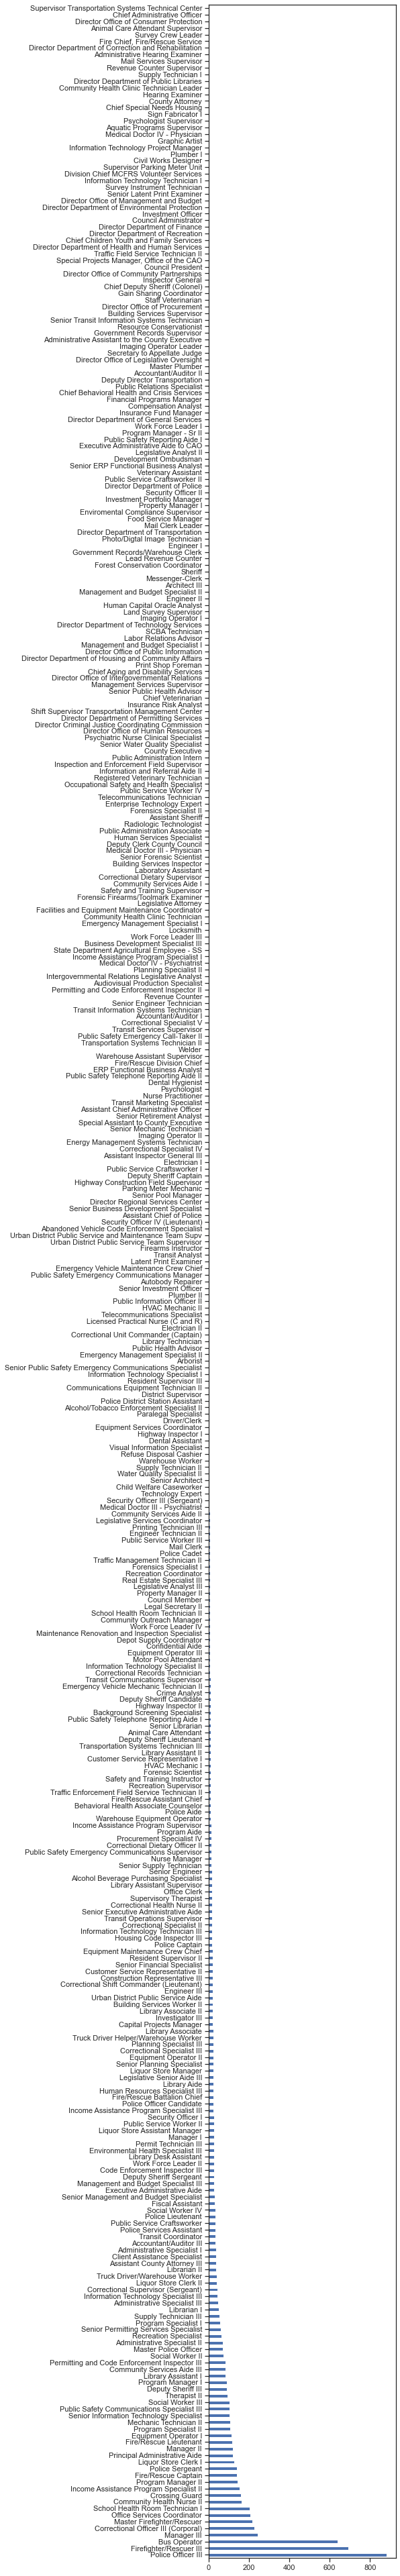

In [46]:
# Some values (job positions) are much more frequent than others
X['employee_position_title'].value_counts().plot(kind='barh', figsize=(5,70));

There are a few numeric features as well, with different distributions.

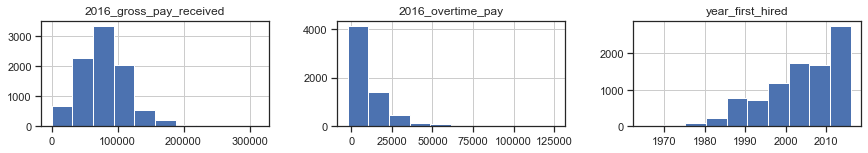

In [47]:
# Distributions of numeric data
X.hist(layout=(20,4), figsize=(20,50));

Let's see how gender, experience (year first hired) and previous salary correlate with each other and the current salary. There are a few outliers visible. Salaries seem to correlate with last year's salary, but not so much with year of first hire. The effect of gender may require more study.


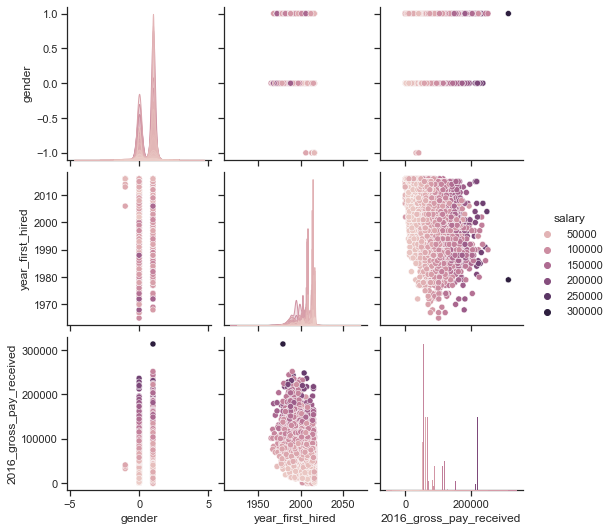

In [48]:
import seaborn as sns
subset = ['gender','year_first_hired','2016_gross_pay_received']
X_sub=X[subset].copy()
# Gender is not numeric, but we can make it numeric (0/1) for this plot
X_sub['gender'] = X_sub['gender'].astype('category').cat.codes
X_sub['salary'] = y 
sns.set(style="ticks")
sns.pairplot(X_sub, hue="salary");

## Part 1: Data cleaning (12 points)

### Question 1.1: A simple pipeline (4 points)
We will first need to build a machine learning pipeline to minimally preprocess the data and analyse models in a meaningful way, while avoiding data leakage in the evaluation. Implement a function `simple_pipeline` that returns an sklearn pipeline that preprocesses the data in a minimal way before running a given algorithm:
- Categorical features:
    - Impute missing values by replacing them with the most frequent value for that feature
    - Perform one-hot encoding. Use `sparse=False` to avoid that it returns a sparse datasets. Use `handle_unknown='ignore'` to ignore categorical values that where not seen during training.
- Numeric features:
    - Replace missing values with '0'. This seems most logical since a missing salary or overtime pay likely means that it was 0.

Note that you only need to build the pipeline, not fit it on the data. You are given the data X, but you cannot use it to train any models.

In [49]:
from sklearn.compose import make_column_transformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import make_pipeline

# Implement
def simple_pipeline(X, model):
    """ Returns a minimal pipeline that imputes missing values and does one-hot-
        encoding for categorical features
    Keyword arguments:
    X -- The input data. Only used to identify features types (eg. numeric/
         categorical), not for training the pipeline.
    model -- any scikit-learn model (e.g. regressor or classifier)
    Returns: an (untrained) scikit-learn pipeline which preprocesses the data 
             and then runs the classifier
    """
    # List of numerical features. You get this for free :)
    numerical = X.select_dtypes(exclude=["category","object"]).columns.tolist()
    numeric_transformer = SimpleImputer(strategy='constant', fill_value=0)

    categorical_transformer = make_pipeline(SimpleImputer(strategy='most_frequent'), OneHotEncoder(sparse=False, handle_unknown='ignore'))
    transformer = make_column_transformer((numeric_transformer, numerical), remainder=categorical_transformer)
    pipe = make_pipeline(transformer, model)
    
    return pipe

#### Sanity check
To be correct, this pipeline should be able to fit any model without error. Uncomment and run this code to do a sanity check.

In [50]:
from sklearn.tree import DecisionTreeRegressor
simple_pipeline(X, DecisionTreeRegressor()).fit(X,y)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                              SimpleImputer(strategy='most_frequent')),
                                                             ('onehotencoder',
                                                              OneHotEncoder(handle_unknown='ignore',
                                                                            sparse=False))]),
                                   transformers=[('simpleimputer',
                                                  SimpleImputer(fill_value=0,
                                                                strategy='constant'),
                                                  ['2016_gross_pay_received',
                                                   '2016_overtime_pay',
                                                   'year_first_hired'])])),
                ('decisiontreeregressor', Decisi

### Question 1.2: A simple wrapper (4 points)
Use a simple wrapping approach to find unnecessary features using backward selection:
* Implement a function 'backward_selection' that selects features using backward selection, each time removing the least useful feature. In the end it should return a list with the removed features.
* 'Least useful' is decided based on the performance of the given pipeline (the `simple_pipeline` that you implemented) together with a 3-nearest neighbor model.
* For the evaluation, use 3-fold shuffled crossvalidation and r2 score (coefficient of determination), using the `simple_pipeline` that you implemented. Use `random_state=0` for the shuffling. To speed things up, you can use training sets of 40% of the data and test sets of 10% of the data.
* Don't actually change the input data X. Make a copy if you want to remove features.
* As shown below, run your model and return a list with the 5 removed features.

In [51]:
from sklearn.linear_model import Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import ShuffleSplit

# Implement
def backward_selection(X, y, pipe, nr_remove=5):
    """ Evaluates the importance of the features in input data X, using the 
    given pipeline and 3-fold cross-validation.
    Returns: The list of the least important features.
    Keyword arguments:
    X -- The input data
    y -- The labels
    pipe -- A machine learning pipeline to be evaluated
    nr_remove -- The number of features to remove
    """
    removed_features = []
    X_sub = X.copy()
    candidate = None
    for i in range(nr_remove):
        max_score = 0
        if candidate:
            X_sub = X_sub.drop([candidate], axis=1)
        for feature in X_sub.columns:
            X_rest = X_sub.drop([feature], axis=1)
            model = KNeighborsRegressor(n_neighbors=3)
            my_pipe = pipe(X_rest, model)
            # kfold = KFold(n_splits=3, shuffle=True, random_state=0)
            cv = ShuffleSplit(n_splits=3, test_size=0.1, train_size=0.4, random_state=0)
            score = np.mean(cross_val_score(my_pipe, X_rest, y, cv=cv, n_jobs=-1, scoring='r2'))
            if score > max_score:
                max_score = score
                candidate = feature
            X_rest = X_sub.copy()
        removed_features.append(candidate)
    
    return removed_features

backward_selection(X, y, simple_pipeline, nr_remove=5)
# [{'date_first_hired': 0.9325483791638058},
#  {'year_first_hired': 0.9326195820347776},
#  {'full_name': 0.9326195820347776},
#  {'division': 0.9326195820347776},
#  {'employee_position_title': 0.9326195820347776}]

['date_first_hired',
 'year_first_hired',
 'full_name',
 'division',
 'employee_position_title']

### Question 1.3: Interpretation (2 points)
* Based on these results, and your out inspection of the data, make a decision on what to do with the features 'full_name', 'department', and 'date_first_hired'. Don't worry if these are not the ones you detected in question 1.2. Can you safely remove these features and is it wise to do so? Also consider any potential ethical issues. Which of the following are correct? Fill in your answer in `q_1_2`. Enter your answer as a comma-separated string without spaces-valued, e.g. "A,B,C"

 * 'A': The feature 'full_name' should be removed since it is unique, which is bad for modelling.
 * 'B': The feature 'full_name' should be removed since it contains people's names, which is unethical.
 * 'C': The feature 'full_name' should be kept. The one-hot encoder can handle  these kind of features efficiently, and it will make the model more flexible.
 * 'D': The feature 'department' should be removed since it is a duplicate feature with 'department_name'.
 * 'E': The feature 'department' provides useful extra information and should  be kept.
 * 'F': The feature 'date_first_hired' is redundant since there is a 'year_first_hired' feature as well, so it can be removed.
 * 'G': The feature 'date_first_hired' should be encoded differently or removed.
 * 'H': The feature 'date_first_hired' is more informative as a category feature than a numeric timestamp, so it should be kept. 
 * 'I': No answer

In [52]:
# Fill in the correct answer. Don't change the name of the variable
q_1_3 = "A,B,D,G"

### Question 1.4: Dimensionality (2 points)
From here, and for the rest of the assignment, we'll remove the three columns discussed in question 1.3 as done below (we overwrite 'X' for convenience). We also remove '2016_gross_pay_received' and '2016_overtime_pay' as they are very closely linked to the target column ('current salary'), hence making this task a little too easy.

Next question: How many features are still being constructed by your `simple_pipeline` (i.e. on how many features is the classifier trained)? Fill in this number in `q_1_4`.

In [53]:
cols = [c for c in X.columns if c.lower() not in ['full_name','department','date_first_hired','2016_gross_pay_received', '2016_overtime_pay']]
X = X[cols]

In [54]:
# uncomment to check whether feature_num is equal to 1206
# the result is 1206 locally, but changes to 12731 when running verify.py

# numerical = X.select_dtypes(exclude=["category","object"]).columns.tolist()
# categorical = X.select_dtypes(include=["category","object"]).columns.tolist()
# X_num = X[numerical]
# X_cat = X[categorical]
# X_num = SimpleImputer(strategy='constant', fill_value=0).fit_transform(X_num)
# X_cat = SimpleImputer(strategy='most_frequent').fit_transform(X_cat)
# X_cat = OneHotEncoder(sparse=False, handle_unknown='ignore').fit_transform(X_cat)
# feature_num = X_cat.shape[1] + X_num.shape[1]
# print(feature_num)
q_1_4 = 1206

1206


## Part 2: Encoders (16 points)

### Question 2.1: A flexible pipeline (2 points)
Implement a function `flexible_pipeline` that has two additional options:
- Allow to choose a feature scaling method for numeric features. The default is standard scaling. 'None' means no scaling
- Allow to choose a feature encoding method for categorical features. The default is one-hot encoding.

In [18]:
# Implement
from sklearn.preprocessing import StandardScaler, OneHotEncoder
def flexible_pipeline(X, model, scaler=StandardScaler(), encoder=OneHotEncoder()):
    """ Returns a pipeline that imputes all missing values, encodes categorical features and scales numeric ones
    Keyword arguments:
    X -- The input data. Only used to identify features types (eg. numeric/categorical), not for training the pipeline.
    model -- any scikit-learn model (e.g. a classifier or regressor)
    scaler -- any scikit-learn feature scaling method (Optional)
    encoder -- any scikit-learn category encoding method (Optional)
    Returns: a scikit-learn pipeline which preprocesses the data and then runs the trained model
    """

    categorical = X.select_dtypes(include=["category","object"]).columns.tolist()
    if scaler:
        numeric_transformer = make_pipeline(SimpleImputer(strategy='constant', fill_value=0), scaler)
    else:
        numeric_transformer = SimpleImputer(strategy='constant', fill_value=0)

    categorical_transformer = make_pipeline(SimpleImputer(strategy='most_frequent'), encoder)
    transformer = make_column_transformer((categorical_transformer, categorical), remainder=numeric_transformer)
    pipe = make_pipeline(transformer, model)
    return pipe

#### Sanity check
To be correct, this pipeline should be able to fit any model and encoder without error. Uncomment and run this code to do a sanity check.

In [19]:
flexible_pipeline(X, DecisionTreeRegressor(random_state=0), encoder=OneHotEncoder()).fit(X,y)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                              SimpleImputer(fill_value=0,
                                                                            strategy='constant')),
                                                             ('standardscaler',
                                                              StandardScaler())]),
                                   transformers=[('pipeline',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder())]),
                                                  ['gender', 'department_name',
                         

### Question 2.2: Comparing encoders (4 points)
Implement a function `plot_2_2` which plots a heatmap comparing several combinations of catergory encoders and models:
* As model, the following algorithms in their default hyperparameters settings: 
    * Ridge regression
    * Lasso regression
    * Random Forests
    * Gradient Boosting
* As encoders, use the following options in their default settings:
    * One-Hot encoder (with `sparse=False`)
    * Ordinal encoder
    * Target encoder

Always use standard scaling. You should evaluate all pipelines using r2 score (coefficient of determination) with 5-fold cross-validation. 
Compare all methods with the same cross-validation folds, shuffle the data and use `random_state=0`. Where possible, also use `random_state=0` for the models. 
Only report the test scores (not the training scores).

Note 1: When encoding categorical values, it is possible to see a category at test time that you did not see at training time, in which case you don't have an encoding for that category, resulting (by default) in an error. For one-hot encoded categories, you can work around this by ignoring the category (all one-hot encoded features will then be zero). For ordinal encoding, you can assing a new value (e.g. '-1') for all unknown categories. For target encoding, the default is to return the target mean. These strategies can be set when creating the encoding.

Note 2: TargetEncoding is part of the `category_encoders` extension of scikit-learn. [Read more about it.](https://contrib.scikit-learn.org/category_encoders/targetencoder.html)
We found that the implementation may have a bug that returns NaN values. You can work around it by wrapping it in a small pipeline followed by a SimpleImputer that replaces NaNs with the mean of the encoded values.

In [20]:
### Helper plotting function. Do not change.
import seaborn as sns
def heatmap(columns, rows, scores):
    """ Simple heatmap.
    Keyword arguments:
    columns -- list of options in the columns
    rows -- list of options in the rows
    scores -- numpy array of scores
    """
    plt.figure() 
    df = pd.DataFrame(scores, index=rows, columns=columns)
    sns.heatmap(df, cmap='RdYlGn_r', linewidths=0.5, annot=True, fmt=".3f")

/Users/huruichen/miniforge3/envs/env_tf/lib/python3.9/site-packages/statsmodels/compat/pandas.py:65: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex
/Users/huruichen/miniforge3/envs/env_tf/lib/python3.9/site-packages/statsmodels/compat/pandas.py:65: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex
/Users/huruichen/miniforge3/envs/env_tf/lib/python3.9/site-packages/statsmodels/compat/pandas.py:65: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex
/Users/huruichen/miniforge3/envs/env_tf/lib/python3.9/site-packages/statsmodels/compat/pandas.

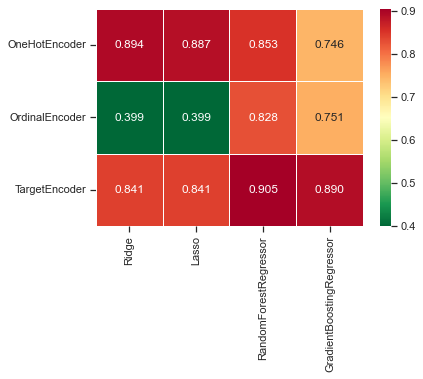

In [21]:
from category_encoders import TargetEncoder
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import OrdinalEncoder

# Implement
def plot_2_2(X, y):
    """ Evaluates a range of models with different categorical encoders and 
    plots the results in a heat map.
    """
    models = [Ridge(random_state=0), 
              Lasso(random_state=0), 
              RandomForestRegressor(random_state=0, n_jobs=-1), 
              GradientBoostingRegressor(random_state=0)]

    encoders = [OneHotEncoder(sparse=False, handle_unknown='ignore'), 
                OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1),
                TargetEncoder()]
    
    result = []
    for encoder in encoders:
        cv = ShuffleSplit(n_splits=5, random_state=0)
        result_per_encoder = []
        for model in models:
            X_sub = X.copy()
            pipe = flexible_pipeline(X_sub, model, encoder=encoder)
            # all models trained with the same folder?
            score = cross_val_score(pipe, X_sub, y, cv=cv, n_jobs=-1, scoring='r2').mean()
            result_per_encoder.append(score)
        result.append(np.array(result_per_encoder))
    
    scores = np.array(result)
    columns = [model.__class__.__name__ for model in models]
    rows = [encoder.__class__.__name__ for encoder in encoders]
    heatmap(columns=columns, rows=rows, scores=scores)
    return 
    
plot_2_2(X, y)

### Question 2.3: Interpretation (2 points)
Interpret the results as well as you can:
- Which models work well in combination with certain encoders? Why do you think that is? Consider the following:
- How do you explain the cases where performance is not good?
- What is the effect on the encodings on training time?
- Some encoders produce lots of features while others produce very few. What is the effect of that on different kinds of models?

Indicate which of the following are correct? Fill in your answer in `q_2_3`. Enter your answer as a comma-separated string without spaces-valued, e.g. "A,B,C"

 * 'A': The best performance with one-hot-encoders is seen with linear models, since they can learn complex functions in the high-dimensional space created by one-hot-encoders.
 * 'B': The linear models work well, no matter the encoding.
 * 'C': The linear models do not work well with ordinal encoding, since linear models will assume that the ordering implies a meaningful distance between categories.
 * 'D': The best performance is seen with RandomForests and Gradient Boosting
 * 'E': Decision-tree based ensembles work well with ordinal encodings (better than linear models), since they can build sub-trees for each individual encoder value.
 * 'F': Decision-tree based ensembles do not work well with ordinal encodings, because the ordering is meaningless in this case.
 * 'G': Decision-tree based ensembles work well with ordinal encodings, because they can make good use of the ordering of the categories.
 * 'H': Decision-tree based ensembles can handle different kinds of encodings rather well.
 * 'I': Target encoding works generally well because it captures key information in one or a few features without significantly increasing the dimensionality of the data, like one-hot encoders do.
 * 'J': Target encoding doesn't work well for regression problems since it only creates one new feature.
 * 'K': Target encoding does not work well here, likely because the categorical features are quite skewed, with only a few examples of some categories.
 * 'L': No answer.


In [22]:
# Fill in your explanation. Don't change the name of the variable
q_2_3 = "A,C,E,I"

### Question 2.4: Categorical Feature Embeddings (6 points)
Now, for something special, we will try the 'SuperVectorizer', a new automated feature encoder that tries to build the best encoding based on how many distinct categories there are. It is also robust against features with many possible values and even typos in category names. In these cases, it encodes features by learning an 'embedding' (a numeric vector representation) based on the similarity of category names. [Read more about it here](https://arxiv.org/abs/1907.01860) but be aware that the paper is quite technical :).

* Implement a function `create_embeddings` that uses the 'SuperVectorizer' to generate an embedding for each employee.
  * Note: The SuperVectorizer only works on string features, so create a copy of X and convert all non-numeric features to strings.


* Visualize the embedding using a dimensionality reduction technique, [tSNE](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html). Please read up on it a bit if you have never heard of it before.
* This should compress `X_embed` from (num_employees, embedding_size) to an  array of size (num_employees, 2) 
  * Make sure that you don't overwite `X`
* Implement a function `plot_tsne` that plots the 2D vector as a scatter plot, color-coded by the salary

In [23]:
from dirty_cat import SuperVectorizer

# Your implementation goes here
def create_embeddings(X, y):
  """ Embeds all categorical features using the SuperVectorizer
  Returns a dataframe X with the embedded representation
  X -- The input data.
  y -- The target values
  """ 
  X_sub = X.copy()
  categorical = X_sub.select_dtypes(include=["category","object"]).columns.tolist()
  X_sub[categorical] = X_sub[categorical].astype(str)
  sv = SuperVectorizer()
  X_embed = sv.fit_transform(X_sub, y)
  return X_embed

X_embed = create_embeddings(X, y)

In [24]:
from sklearn.manifold import TSNE

# Your implementation goes here
def compute_tsne(X):
  """ Applies tSNE to build a 2D representation of the data
  Returns a dataframe X with the 2D representation
  X -- The input data
  """
  return TSNE(n_components=2, learning_rate='auto', init='random', n_jobs=-1).fit_transform(X)

X_embed_reduced = compute_tsne(X_embed)

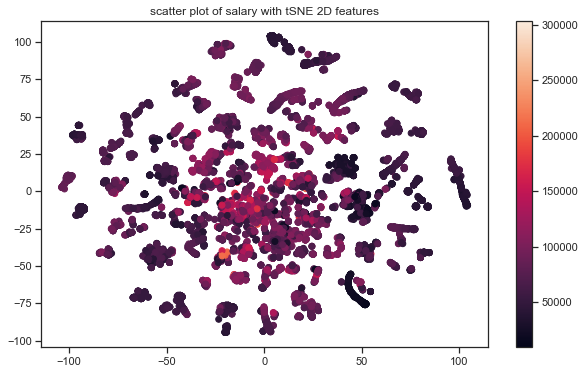

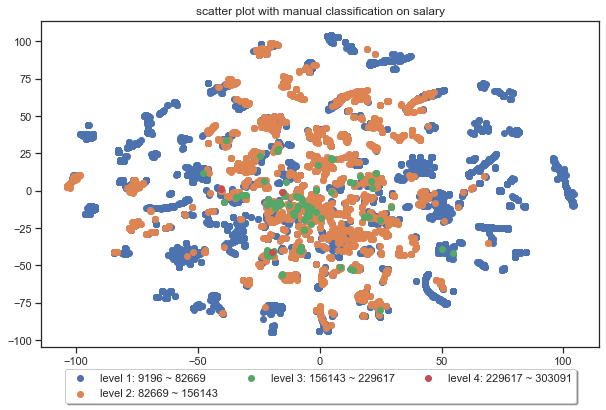

In [25]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
# Your implementation goes here
def plot_tsne(tsne_embeds, scores):
  """ Plots the given 2D data points, color-coded by score
  tsne_embeds -- The tSNE embeddings of all employees
  scores -- The corresponding salaries
  """
  # without classification
  fig, axes = plt.subplots(1, 1, figsize=(10, 6))
  axes.set_title("scatter plot of salary with tSNE 2D features")
  sc = axes.scatter(tsne_embeds[:, 0], tsne_embeds[:, 1], c=y)
  fig.colorbar(sc)

  # manually classified
  level_num = 5
  level = np.linspace(min(y), max(y), num=level_num)

  salary_level = []
  prev = str(int(level[0]))
  for i in range(1, len(level)):
      title = "level {}: ".format(i)
      salary_level.append(title + prev + " ~ " + str(int(level[i])))
      prev = str(int(level[i]))

  y_label = []
  for target in y:
      for i in range(len(level)):
          if target >= level[i] and target <= level[i + 1]:
              y_label.append(i + 1)
              break

  y_label = np.array(y_label)
  X_groupped = []
  for i in range(1, len(salary_level) + 1):
      indices = np.where(y_label == i)[0]
      X_groupped.append(tsne_embeds[indices])

  fig, axes = plt.subplots(1, 1, figsize=(10, 6))
  axes.set_title("scatter plot with manual classification on salary")
  for X_each, label in zip(X_groupped, salary_level):
      axes.scatter(X_each[:, 0], X_each[:, 1], label=label)
  axes.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=3, prop={'size':11});

plot_tsne(X_embed_reduced, y)

Interpret the result. Indicate which of the following are correct? Fill in your answer in `q_2_4`. Enter your answer as a comma-separated string without spaces, e.g. "A,B,C".

 * 'A': Some groups of employees clearly clusters together
 * 'B': The result is entirely random because the embedding doesn't manage to preserve the information in the original data.
 * 'C': Some groups of employees with a high salary cluster together
 * 'D': Some groups of employees with a low salary cluster together
 * 'E': The clusters are all clearly delineated
 * 'F': No answer

In [26]:
# Fill in your answer. Don't change the name of the variable
q_2_4 = "A,D"

### Question 2.5: Compare again (2 points)
* Implement a function `plot_2_5` that evaluates the same algorithms as in question 2.2, and returns a heatmap (just as in question 2.2), but now using the SuperVectorizer.


/Users/huruichen/miniforge3/envs/env_tf/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.638e+09, tolerance: 7.072e+08
  model = cd_fast.enet_coordinate_descent(
/Users/huruichen/miniforge3/envs/env_tf/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.777e+10, tolerance: 7.136e+08
  model = cd_fast.enet_coordinate_descent(
/Users/huruichen/miniforge3/envs/env_tf/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the featu

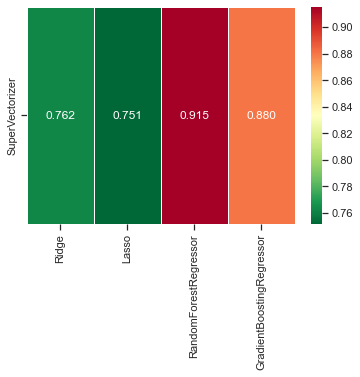

In [27]:
# Implement
def plot_2_5(X, y):
    """ Plots a heatmap for the different encoder options
    Keyword arguments:
    X -- The input data
    y -- The target labels
    Returns a heatmap
    """
    models = [Ridge(random_state=0), 
            Lasso(random_state=0), 
            RandomForestRegressor(random_state=0), 
            GradientBoostingRegressor(random_state=0)]

    encoders = [SuperVectorizer()]
    
    result = []
    for encoder in encoders:
        cv = ShuffleSplit(n_splits=5, random_state=0)
        result_per_encoder = []
        for model in models:
            X_sub = X.copy()
            pipe = flexible_pipeline(X_sub, model, encoder=encoder)
            # all models trained with the same folder?
            score = cross_val_score(pipe, X_sub, y, cv=cv, n_jobs=-1, scoring='r2').mean()
            result_per_encoder.append(score)
        result.append(np.array(result_per_encoder))
    
    scores = np.array(result)
    columns = [model.__class__.__name__ for model in models]
    rows = [encoder.__class__.__name__ for encoder in encoders]
    heatmap(columns=columns, rows=rows, scores=scores)
    return
    
plot_2_5(X, y)

Interpret the result. Indicate which of the following are correct? Fill in your answer in `q_2_5`. Enter your answer as a comma-separated string without spaces, e.g. "A,B,C".

 * 'A': We get the best results so far, especially with the random forests and gradient boosting.
 * 'B': The results are about the same as the one-hot-encoder we saw in question 2.2.
 * 'C': The learned embeddings seems useful to capture information about which categories are similar (e.g. which employee positions are similar). 
 * 'D': Embeddings don't work well for decision-tree based models, one-hot encoding works much better.
 * 'E': No answer


In [28]:
# Fill in your answer. Don't change the name of the variable
q_2_5 = "C"

## Part 3: Feature importance (6 points)
In this part, we will continue with your `flexible_pipeline`, and we use a random forest to learn which features
are most important to predict the salary of a person. This may reveal how salaries are decided. We will do this with both Random Forest's importance estimates and with permutation importance.

### Question 3.1: Model-based feature importance (4 points)
Implement a function `plot_3_1` that does the following:  
* Split the data using a standard shuffled train-test split. Use `random_state=0`.
* Combine your `flexible_pipeline`, without feature scaling but with one-hot-encoding, with a RandomForest regressor. Train that pipeline on the training set.
* Remember that the categorical features were encoded. Retrieve their encoded names from the one-hot-encoder (with `get_feature_names`). You can get the encoder from the trained pipeline or ColumnTransformer. Carefully check the documentation.
* Retrieve the feature importances from the trained random forest and match them to the correct names. Depending on how you implemented your `flexible_pipeline` these are likely the first or the last columns in the processed dataset.
* Compute the permutation importances given the random forest pipeline and the test set. Use `random_state=0` and at least 10 iterations.
* Pass the tree-based and permutation importances to the plotting function `compare_importances` below.

In [29]:
# Plotting function. Do not edit.
def compare_importances(rf_importance, perm_importance, rf_feature_names, feature_names):
    """ Compares the feature importances from random forest to permutation importance
    Keyword arguments:
    rf_importance -- The random forest's feature_importances_
    perm_importance -- The permutation importances as computed by sklearn.inspection.permutation_importance
    rf_feature_names -- The names of the features received by the random forest, in the same order as their importances
    feature_names -- The original features names in their original order
    """
    topk = 30
    # Trees
    sorted_idx = rf_importance.argsort()[-topk:]
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
    y_ticks = np.arange(0, topk)
    ax[0].barh(y_ticks, rf_importance[sorted_idx])
    ax[0].set_yticklabels(rf_feature_names[sorted_idx])
    ax[0].set_yticks(y_ticks)
    ax[0].set_title("Random Forest Feature Importances")

    # Permutations
    sorted_idx = perm_importance.importances_mean.argsort()[-topk:]
    ax[1].boxplot(perm_importance.importances[sorted_idx].T, vert=False, labels=feature_names[sorted_idx])
    ax[1].set_title("Permutation Importances (test set)")

    fig.tight_layout()
    plt.show()

/var/folders/x0/sdmkrwmd58q43wyjnxrkcs6h0000gn/T/ipykernel_18370/629188122.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_yticklabels(rf_feature_names[sorted_idx])


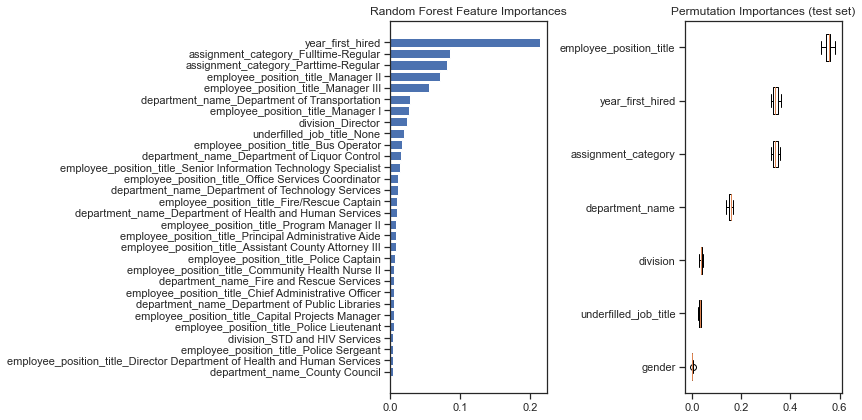

In [30]:
from sklearn.inspection import permutation_importance

# Implement
def plot_3_1(X, y):
    """ See detailed description above.
    """
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, shuffle=True)
    pipe = flexible_pipeline(X, RandomForestRegressor(n_jobs=-1), scaler=None, encoder=OneHotEncoder(handle_unknown='ignore'))
    rf = pipe.fit(X_train, y_train)
    rf_importance = rf.named_steps['randomforestregressor'].feature_importances_

    categorical = X.select_dtypes(include=["category","object"]).columns.tolist()
    rf_feature_names = rf['columntransformer'].transformers_[0][1]['onehotencoder'].get_feature_names(categorical)
    numerical = X.select_dtypes(exclude=["category","object"]).columns.tolist()
    rf_feature_names = np.append(rf_feature_names, numerical)

    perm_importance = permutation_importance(rf, X_test, y_test, n_repeats=10, random_state=0, n_jobs=-1)
    feat_names = X.columns

    compare_importances(rf_importance=rf_importance,
                        perm_importance=perm_importance,
                        rf_feature_names=rf_feature_names,
                        feature_names=feat_names)
plot_3_1(X, y)

### Question 3.2: Interpretation (2 point)
Interpret the results of Question 3.1. What seems to affect salary the most? Do both methods give the same or similar results? If not, what are the differences? Try to explain these differences based on your understanding of how these methods work.

Indicate which of the following are correct? Fill in your answer in `q_3_2`. Enter your answer as a comma-separated string without spaces, e.g. "A,B,C"

 * 'A': The exact ranking differs a bit because, due to the one-hot-encoding, we get an importance per category in the the model-based feature importances.
 * 'B': Overall, the results are quite similar. The year of first hire, assignment category (fulltime/parttime), and the position title have the most influence on salary.
 * 'C': There are some key differences. Some of the most important features in one method are the least important in the other.
 * 'D': Only some job categories (employee positions) affect salary greatly (e.g. manager) 
 * 'E': Gender only shows up in the permutation importances, and with a very low importance. 
 * 'F': Gender is important according to both methods.
 * 'H': Year of first hire is not important according to both methods. 
 * 'G': Year of first hire is very important according to one method, yet not at all important by the other. 
 * 'I': Year of first hire is important according to both methods.
 * 'J': No answer




In [31]:
# Fill in your answer. Don't change the name of the variable
q_3_2 = "A,B,D,E,I"

## Part 4: Algoritmic bias (6 points)
Check whether there is any algorithmic bias in the predictions.

### Question 4.1: Gender bias (3 points)
First, we want to check whether the model gives better predictions for males or for females.

* Use a RandomForest pipeline with 100 trees and `max_features=0.1`
* Use 3-fold cross validation and return the predictions for every fold.
  * Hint: sklearn has methods that return the predictions for cross-validation splits (instead of only a score).
* Separate the test set predictions into different groups depending on the feature 'gender', and report the r2 score for each group.
* Implement a function `plot_4_1` which returns a simple bar chart visualizing both scores.

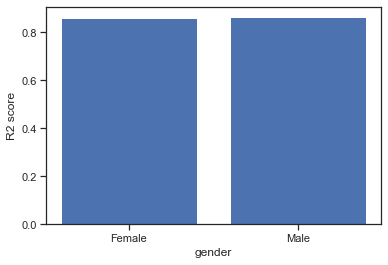

Female r2 score: 0.8601884622984441
Male r2 score: 0.8631930432822503
Female - Male: -0.003004580983806182


In [32]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import r2_score
#Implement
def plot_4_1(X, y):
    """ Returns a bar chart of the R2 measured, grouped by the value for the 'gender' feature
    """
    pipe = flexible_pipeline(X, RandomForestRegressor(n_estimators=100, max_features=0.1, n_jobs=-1), scaler=None, encoder=OneHotEncoder(handle_unknown='ignore'))
    pred = cross_val_predict(pipe, X, y, cv=3, n_jobs=-1)
    genders = list(X['gender'].dropna().unique())
    indices_by_gender = [X.index[X['gender'] == gender].tolist() for gender in genders]
    r2_scores = [r2_score(y[i], pred[i]) for i in indices_by_gender]

    gender_labels = ['Male' if gender == 'M' else 'Female' for gender in genders]
    plt.bar(gender_labels, r2_scores)
    plt.xlabel('gender')
    plt.ylabel('R2 score')
    plt.show()

    for gender, score in zip(gender_labels, r2_scores):
        print("{} r2 score: {}".format(gender, score))    
    print("{} - {}: {}".format(gender_labels[0], gender_labels[1], r2_scores[0] - r2_scores[1]))

plot_4_1(X, y)

Interpret the results. Indicate which of the following are correct. Fill in your answer in `q_4_1`. Enter your answer as a comma-separated values without spaces, e.g. "A,B,C"
 * 'A': The model is much more accurate (more than 1% accuracy difference) in predicting the salaries for males than for females.
 * 'B': The model is about equally accurate for both males and females.
 * 'C': Salaries are equal for both genders.
 * 'D': The model doesn't seem to be biased.
 * 'E': The model is clearly biased.
 * 'F': No answer

In [33]:
# Fill in your answer. Don't change the name of the variable
q_4_1 = "B,D"

### Question 4.2: Instance reweighting (3 points)
Second, since the data contains more males than females, we want to check whether we can get a better model if we balance the data by giving more
weight to the examples about female employees.

* Implement a function `plot_4_2` where you weight the samples (instances) with a weight inversely proportional to their frequency. For instance, male instances should be weighted by $\frac{num\_instances}{num\_males}$, and analogous for females.
* and then visualise the results in the same way as in question 4.1 (as a bar chart).
* Interpret the results and explain them in `answer_q_4_2`.

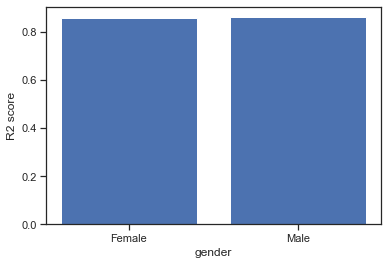

Female r2 score: 0.8596846885899236
Male r2 score: 0.8613370434861958
Female - Male: -0.0016523548962721346


In [34]:
#Implement
def plot_4_2(X, y):
    """ Returns a bar chart of the score measured, grouped by the value for the 'gender' feature
    """
    y_sub = y.copy()
    genders = list(X['gender'].dropna().unique())
    indices_by_gender = [X.index[X['gender'] == gender].tolist() for gender in genders]
    num_by_gender = [(X['gender'] == gender).sum() for gender in genders]
    # how about nan value?
    num_instances = len(X['gender'])
    weight_by_gender = [num_instances/num_gender for num_gender in num_by_gender]

    gender_weight = dict(zip(genders, weight_by_gender))
    most_frequent_gender = X['gender'].dropna().mode()[0]
    # categorical: SimpleImputer, most frequent value
    weights = [gender_weight[i] if pd.isnull(i) == False else gender_weight[most_frequent_gender]
                for i in X['gender']]

    pipe = flexible_pipeline(X, RandomForestRegressor(n_estimators=100, max_features=0.1, n_jobs=-1), scaler=None, encoder=OneHotEncoder(handle_unknown='ignore'))
    pred = cross_val_predict(pipe, X, y_sub, cv=3, fit_params={'randomforestregressor__sample_weight': weights} , n_jobs=-1)
    r2_scores = [r2_score(y_sub[i], pred[i]) for i in indices_by_gender]

    gender_labels = ['Male' if gender == 'M' else 'Female' for gender in genders]
    plt.bar(gender_labels, r2_scores)
    plt.xlabel('gender')
    plt.ylabel('R2 score')
    plt.show()

    for gender, score in zip(gender_labels, r2_scores):
        print("{} r2 score: {}".format(gender, score))    
    print("{} - {}: {}".format(gender_labels[0], gender_labels[1], r2_scores[0] - r2_scores[1]))
    
plot_4_2(X, y)

Interpret the results. Indicate which of the following are correct. Fill in your answer in `q_4_2`. Enter your answer as a comma-separated values without spaces, e.g. "A,B,C"
 * 'A': The model is now much better at predicting the salaries of females.
 * 'B': The model is now much worse at predicting the salaries of females.
 * 'C': The model is only marginally better at predicting the salaries of females than before.
 * 'D': Salaries are now equal for both genders.
 * 'E': The unbalance between males and females was not so large, and the model was already quite good, so the instance weighting didn't do much.
 * 'F': The model still is clearly biased.
 * 'G': No answer

In [35]:
# Fill in your answer. Don't change the name of the variable
q_4_2 = "E"

In [36]:
print(time.time()-start_time)

303.42991399765015
